In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, remove_small_objects
from scipy.spatial import KDTree
from scipy.interpolate import splprep, splev
from scipy.interpolate import interp1d
from PIL import Image

In [2]:
def rgb_to_binary(image_path, blur_kernel=(5, 5), canny_thresholds=(50, 150)):
    """
    Converts an RGB image into a binary image, retaining all essential features.
    0s represent background,
    1s represent edges.

    Parameters:
        image_path (str): Path to the input RGB image.
        blur_kernel (tuple): Kernel size for Gaussian blur (default: (5,5)).
        canny_thresholds (tuple): Min and max thresholds for Canny edge detection (default: (50,150)).

    Returns:
        binary_image (numpy.ndarray): 2D binary image with values 0 (background) and 1 (edges).
    """
    # 1. Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 2. Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # 3. Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, blur_kernel, 0)

    # 4. Apply Canny edge detection
    edges = cv2.Canny(blurred, canny_thresholds[0], canny_thresholds[1])

    # 5. yield binary image
    binary_image = (edges > 0).astype(np.uint8)

    return binary_image

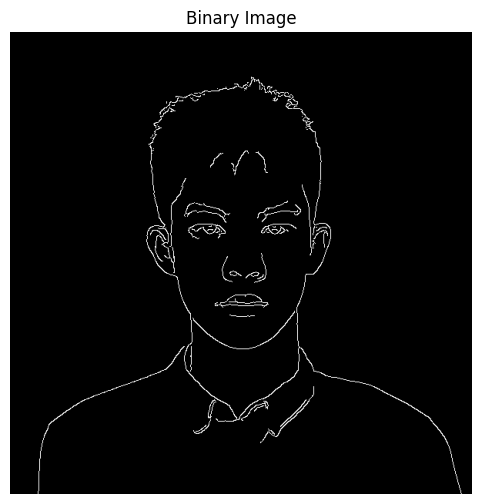

In [3]:
image_path = os.path.join('my_picture.jpg')
# image_path = os.path.join('temp/18bcd7130 gg.jpg')
binary_result = rgb_to_binary(image_path)

# Display the binary image
plt.figure(figsize=(8, 6))
plt.imshow(binary_result, cmap='gray')
plt.axis('off')  # Hide axes
plt.title("Binary Image")
plt.show()

In [10]:
binary_img = np.array(binary_result)
init_nodes = np.sum(binary_img)
print("Initial number of nodes: ", init_nodes)
print("Time for all nodes at 0.1s per node: ", init_nodes*0.1/60, "minutes")

Initial number of nodes:  4811
Time for all nodes at 0.1s per node:  8.018333333333334 minutes


In [5]:
def create_graph(binary_image):
    G = nx.Graph()
    
    # Add nodes to the graph
    rows, cols = binary_image.shape
    for i in range(rows):
        for j in range(cols):
            if binary_image[i, j] == 1:
                G.add_node((j, i))
    
    # Add edges to the graph
    for i in range(rows):
        for j in range(cols):
            if binary_image[i, j] == 1:
                # Connect with the right pixel
                if j < cols - 1 and binary_image[i, j + 1] == 1:
                    G.add_edge((j, i), (j + 1, i))
                # Connect with the pixel below
                if i < rows - 1 and binary_image[i + 1, j] == 1:
                    G.add_edge((j, i), (j, i + 1))
                # Connect with the bottom-right pixel
                if i < rows - 1 and j < cols - 1 and binary_image[i + 1, j + 1] == 1:
                    G.add_edge((j, i), (j + 1, i + 1))
                # Connect with the bottom-left pixel
                if i < rows - 1 and j > 0 and binary_image[i + 1, j - 1] == 1:
                    G.add_edge((j, i), (j - 1, i + 1))
    return G

In [6]:
def show_images(images, titles=None):
    if titles is None:
        titles = ['Image %d' % i for i in range(1, len(images) + 1)]
    n = len(images)
    if n == 1:
        plt.figure()
        plt.imshow(images[0], cmap='gray')
        plt.axis('off')
        plt.title(titles[0])
    else:
        fig, axes = plt.subplots(1, n, figsize=(15, 15))
        for i in range(n):
            axes[i].imshow(images[i], cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(titles[i])
    plt.show()

In [7]:
# Load the binary image
# image = cv2.imread('temp/binary_image.png', cv2.IMREAD_GRAYSCALE)
# image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)[1]  # Ensure binary format

# Skeletonize the image to get a 1-pixel-wide path
# skeleton = skeletonize(image // 255)

skeleton = skeletonize(binary_result)

# Remove isolated pixels
skeleton2 = remove_small_objects(skeleton, connectivity=2, min_size=7)

# show_images([skeleton, skeleton2], ['Skeleton', 'Skeleton (Cleaned)'])

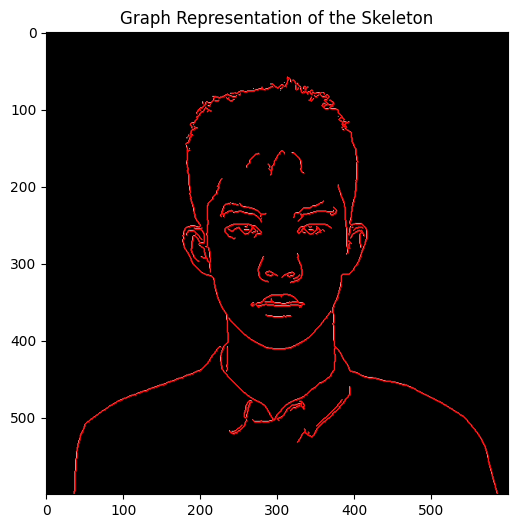

In [8]:
# Extract coordinates of the skeleton
y, x = np.where(skeleton > 0)
points = np.vstack((x, y)).T  # Convert to (x, y) format

# Convert points into a graph
G = create_graph(skeleton)

# Plot the full graph
plt.figure(figsize=(6, 6))
plt.imshow(skeleton, cmap='gray')
for edge in G.edges:
    x1, y1 = edge[0]
    x2, y2 = edge[1]
    plt.plot([x1, x2], [y1, y2], 'r-', linewidth=1, alpha=0.5)
plt.title("Graph Representation of the Skeleton")
plt.show()

Number of nodes in the graph: 3754
Number of edges in the graph: 3736
Number of components in the graph: 82


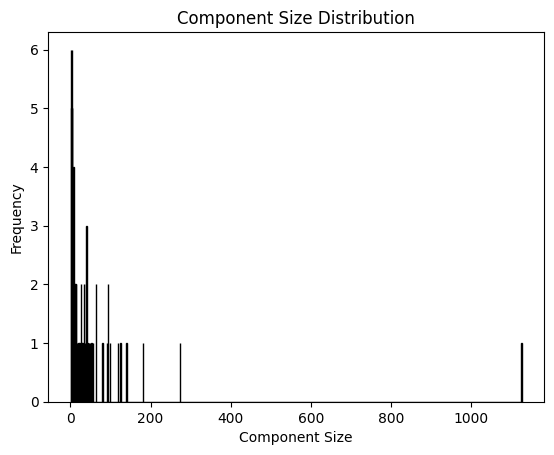

In [9]:
# Number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes in the graph:", num_nodes)
print("Number of edges in the graph:", num_edges)
# Number of components in the graph
num_components = nx.number_connected_components(G)
print("Number of components in the graph:", num_components)
# Number of nodes in each component
component_sizes = [len(c) for c in nx.connected_components(G)]
plt.hist(component_sizes, bins=range(1, max(component_sizes) + 1), color='skyblue', edgecolor='black')
plt.xlabel("Component Size")
plt.ylabel("Frequency")
plt.title("Component Size Distribution")
plt.show()

Number of points after resampling: 1090
Number of points in original paths: 3754


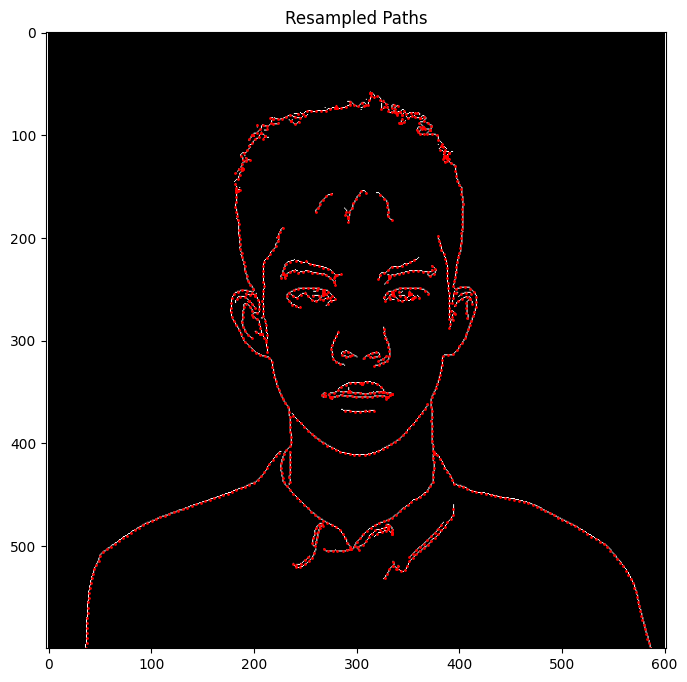

In [59]:
import networkx as nx
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from collections import deque

def extract_branches(graph):
    branches = []
    visited = set()

    # Find all junction nodes (nodes with degree > 2)
    junctions = {node for node in graph.nodes() if graph.degree(node) > 2}

    # Traverse the graph to extract linear paths (branches)
    for node in graph.nodes():
        if node in visited:
            continue

        if graph.degree(node) == 1 or node in junctions:  # Start at leaf or junction
            for neighbor in graph.neighbors(node):
                if (node, neighbor) not in visited and (neighbor, node) not in visited:
                    branch = []
                    queue = deque([(node, neighbor)])  # Start BFS from the branch start

                    while queue:
                        prev, curr = queue.popleft()
                        branch.append(curr)
                        visited.add((prev, curr))
                        visited.add((curr, prev))

                        # If we reach a junction or endpoint, stop
                        if graph.degree(curr) > 2 or graph.degree(curr) == 1:
                            break

                        # Continue to the next neighbor
                        for next_node in graph.neighbors(curr):
                            if (curr, next_node) not in visited:
                                queue.append((curr, next_node))
                                break  # Move in one direction only

                    branches.append([node] + branch)

    return branches

def resample_path(path, target_spacing=2.0):
    """
    Resample a path to have points spaced at a fixed distance.

    :param path: np.array of shape (N, 2), original list of (x, y) coordinates
    :param target_spacing: float, desired distance between consecutive points
    :return: np.array of shape (M, 2), resampled path
    """
    # Compute cumulative distances along the path
    distances = np.cumsum(np.sqrt(np.sum(np.diff(path, axis=0) ** 2, axis=1)))
    distances = np.insert(distances, 0, 0)  # Insert 0 at start

    # Create interpolation functions for x and y
    interp_x = interp1d(distances, path[:, 0], kind='linear')
    interp_y = interp1d(distances, path[:, 1], kind='linear')

    # Generate new sampled distances with equal spacing
    new_distances = np.arange(0, distances[-1], target_spacing)

    # Compute new points
    new_x = interp_x(new_distances)
    new_y = interp_y(new_distances)

    return np.column_stack((new_x, new_y))

target_spacing = 5.0  # Desired spacing between points

# Extract connected components
components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
resampled_paths = []

for idx, component in enumerate(components):
    branches = extract_branches(component)  # Extract branches from component
    for branch in branches:
        resampled_points = resample_path(np.array(branch), target_spacing)
        resampled_paths.append(resampled_points)

# Number of points
num_points = sum(len(path) for path in resampled_paths)
print("Number of points after resampling:", num_points)
print("Number of points in original paths:", len(G.nodes()))

# Plot the resampled paths
plt.figure(figsize=(8, 8))
plt.imshow(skeleton, cmap='gray')
for path in resampled_paths:
    # plt.plot(path[:, 0], path[:, 1], 'r-', linewidth=1)
    plt.scatter(path[:, 0], path[:, 1], s=1, c='r')
# plt.gca().invert_yaxis()
plt.axis('equal')
plt.title("Resampled Paths")
plt.show()